In [1]:
#import all libraries

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Telco Churn predicition and find important features with Recursive feature elimination with cross-validation (RFECV)

## Data preperation

In [2]:
#Retrieve the Dataset from the CSV file
pre_df = pd.read_csv('Telco_Customer_Churn.csv')

In [3]:
#Show the first ten rows of the dataset
pre_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Size of whole dataset
pre_df.shape

(7043, 21)

In [5]:
#Clean table in case of duplicates
pre_df.drop_duplicates(inplace = True)

In [6]:
#Show none rows has been dropped
pre_df.shape

(7043, 21)

In [7]:
# Remove missing values
pre_df.dropna(inplace = True)

In [8]:
#Show none rows has been dropped
pre_df.shape

(7043, 21)

In [9]:
# remove customer ID, because it doesn't affect the reason question
df = pre_df.iloc[:,1:]

In [10]:
# Converting Total Charges to a numerical data type, so it is mutable 
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors= 'coerce')

In [11]:
#How many of the cols have a null value
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
# Show total amount of rows and cols
df.shape

(7043, 20)

In [13]:
#Drop rows where they haven't stayed for more than one month because of total charge is null
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df.shape

(7032, 20)

In [14]:
# check if we have any nulls left
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Make features mutable - from different val to yes and no

In [15]:
# Convert Multiple lines, Online Security, Online Backup, Device Protection, Tech support, Streaming Service, Streaming Movies, so it is mutable
df['MultipleLines'] = df['MultipleLines'].replace("No phone service", "No")
df['OnlineSecurity'] = df['OnlineSecurity'].replace("No internet service", "No")
df['OnlineBackup'] = df['OnlineBackup'].replace("No internet service", "No")
df['DeviceProtection'] = df['DeviceProtection'].replace("No internet service", "No")
df['TechSupport'] = df['TechSupport'].replace("No internet service", "No")
df['StreamingTV'] = df['StreamingTV'].replace("No internet service", "No")
df['StreamingMovies'] = df['StreamingMovies'].replace("No internet service", "No")

#converting senior citizen into category
df['SeniorCitizen'] = df['SeniorCitizen'].replace(1,"Yes")
df['SeniorCitizen'] = df['SeniorCitizen'].replace(0,"No")
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [16]:
#Show the conversion
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Pie Chart - Churn Ratio

### Bar Chart - Churn ratio

Churn
No     5163
Yes    1869
dtype: int64


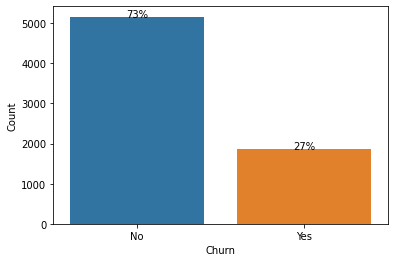

In [17]:
## make barchart
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

In [18]:
#Convertin the predictor variable ( yes and no ) in a binary numeric variable 
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

## Heatmap - correlation with feature and churn

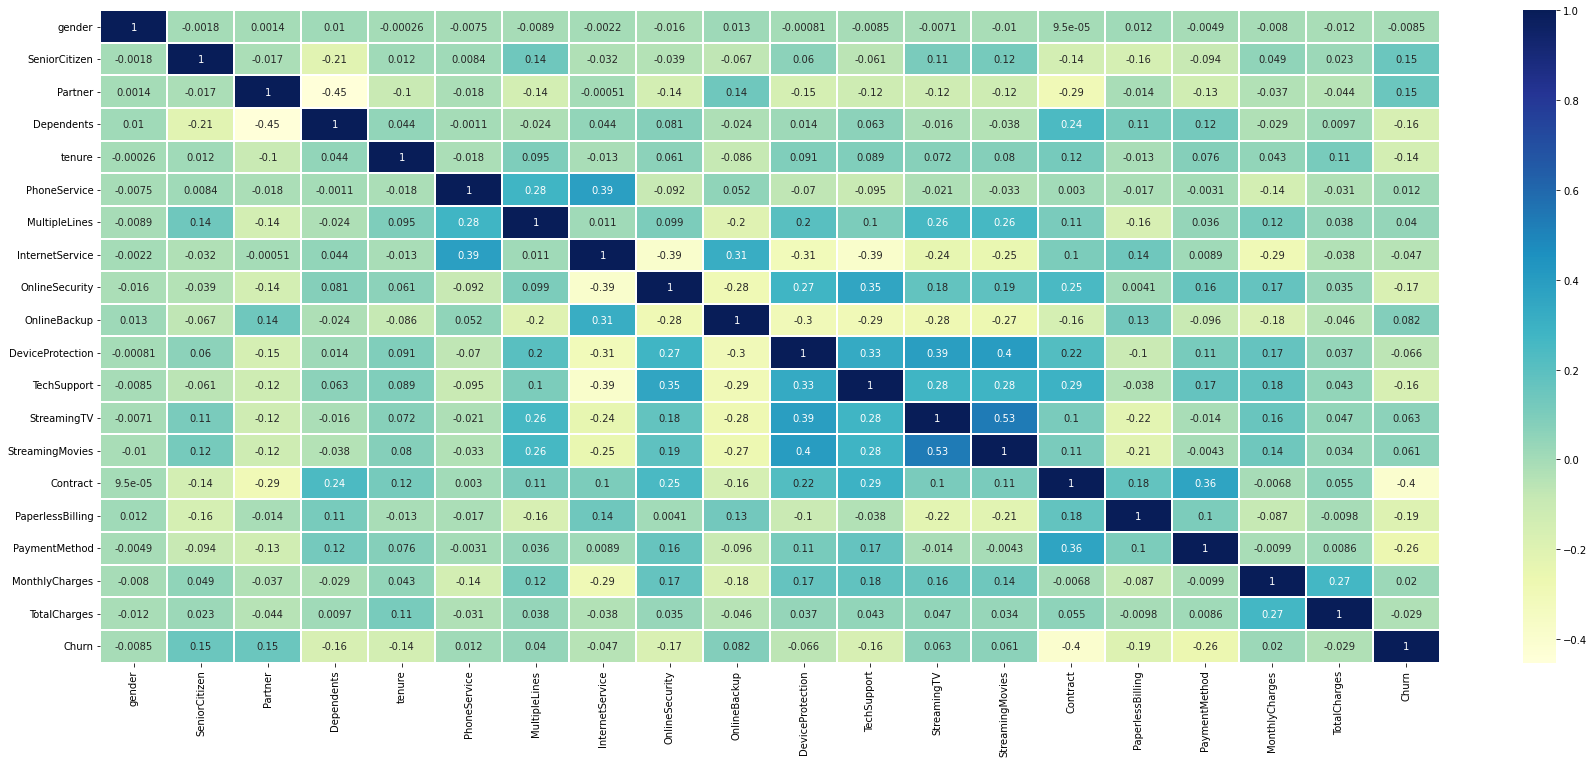

In [19]:
# Create a heat map to illustrate the correlation between feature and Churn

#make figure
plt.figure(
    figsize=(30, 12)
)

# Make the corelation 
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

# Create heatmap
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu", annot = True)

In [20]:
# Remove the two features which doesnt have a correlation to churn
df_new = df.drop(columns=['gender','PhoneService'])

In [21]:
#Get rows and columns count
df_new.shape

(7032, 18)

# Modeling

### Premodeling

In [22]:
# Remove churn for training
Features = df_new.columns.drop('Churn')

In [23]:
# Prepare split for the training data and the test data
X = df_new[Features]
y = df_new['Churn']

Use get_dummies to add the additional features, 'Type of Sale', and 'Type'. You still want to include m2 and 'Build Year'. Note that get_dummies will only create dummy features for nominal values -- it will ignore numerical features like m2 and 'Build Year'. List the dummy features that were created for the feature 'Type'.

In [24]:
X = pd.get_dummies(X)

# show the first 5 rows
X.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0


# Decision trees

#### https://www.kaggle.com/bhartiprasad17/customer-churn-prediction 

### Decision tree - without Cross validation

In [25]:
# Initialize the training set and test set
#Split the  Splits at 25% default
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=69
)

## Find the optimal use of hyper parameters

In [26]:
# example of grid searching key hyperparameters for BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
dc_model = DecisionTreeClassifier()

max_depth_arr = [1,2,4,5,6,7,8,10,20]

# define grid search
grid = dict()
grid['max_depth'] = max_depth_arr;

grid_search = GridSearchCV(
    estimator=dc_model, 
    param_grid=grid, n_jobs=-1, 
    scoring='accuracy',error_score=0
)

grid_result = grid_search.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793137 using {'max_depth': 5}
0.736064 (0.000433) with: {'max_depth': 1}
0.765645 (0.009034) with: {'max_depth': 2}
0.789913 (0.010217) with: {'max_depth': 4}
0.793137 (0.009111) with: {'max_depth': 5}
0.790861 (0.012746) with: {'max_depth': 6}
0.785363 (0.009366) with: {'max_depth': 7}
0.778157 (0.011563) with: {'max_depth': 8}
0.764506 (0.011618) with: {'max_depth': 10}
0.729996 (0.004487) with: {'max_depth': 20}


In [27]:
#create the decision tree classifier
dc = DecisionTreeClassifier(max_depth = 5)

#Train model
dc_model = dc.fit(X_train,y_train)

#predict
Decision_y_pred_rfc = dc_model.predict(X_test)


### Decision tree accuracy - result

In [28]:
print('Accuracy of Decision tree classifier on test set: {:.5f}'.format(dc_model.score(X_test, y_test)))

Accuracy of Decision tree classifier on test set: 0.77702


In [29]:
### Decision tree - 

In [30]:
print(classification_report(y_test,Decision_y_pred_rfc, digits=4))

              precision    recall  f1-score   support

           0     0.8276    0.8767    0.8514      1281
           1     0.6060    0.5094    0.5535       477

    accuracy                         0.7770      1758
   macro avg     0.7168    0.6930    0.7025      1758
weighted avg     0.7674    0.7770    0.7706      1758



In [31]:
dc_imp=list(dc_model.feature_importances_)

dc_colname=list(X_train.columns)

#Create dict for datafram
dc_dict={'Feature':dc_colname,'Importance':dc_imp}

#Create dataframe
dc_feature_imp=pd.DataFrame(dc_dict)
X

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,1,0,0,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1
7039,72,103.20,7362.90,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0
7040,11,29.60,346.45,1,0,0,1,0,1,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
7041,4,74.40,306.60,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1


In [32]:
dc_feature_rank=dc_feature_imp.sort_values(by='Importance',ascending = False)

### decision tree feature importance

In [33]:
dc_feature_rank.head(10)

,Feature,Importance
26,Contract_Month-to-month,0.505002
0,tenure,0.180921
12,InternetService_Fiber optic,0.155176
2,TotalCharges,0.053858
1,MonthlyCharges,0.025204
11,InternetService_DSL,0.024703
28,Contract_Two year,0.013703
9,MultipleLines_No,0.010428
10,MultipleLines_Yes,0.009769
20,TechSupport_No,0.007339


### decision tree confusion matrix - result

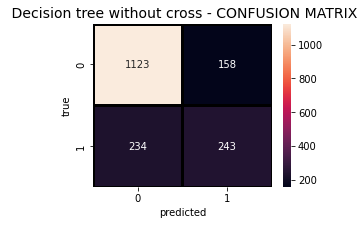

In [34]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, Decision_y_pred_rfc),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" Decision tree without cross - CONFUSION MATRIX",fontsize=14)
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

### Decision tree - Cross Validation

In [35]:
# Evaluation with the RFECV to find the most important the features in regard to accurassy 
# Decision tree Classifier for X 

Decision_rfc = DecisionTreeClassifier(max_depth = 5)

Decision_rfecv = RFECV(estimator = Decision_rfc, step=1, cv=StratifiedKFold(6), scoring='accuracy')
Decision_rfecv_model = Decision_rfecv.fit(X_train,y_train)

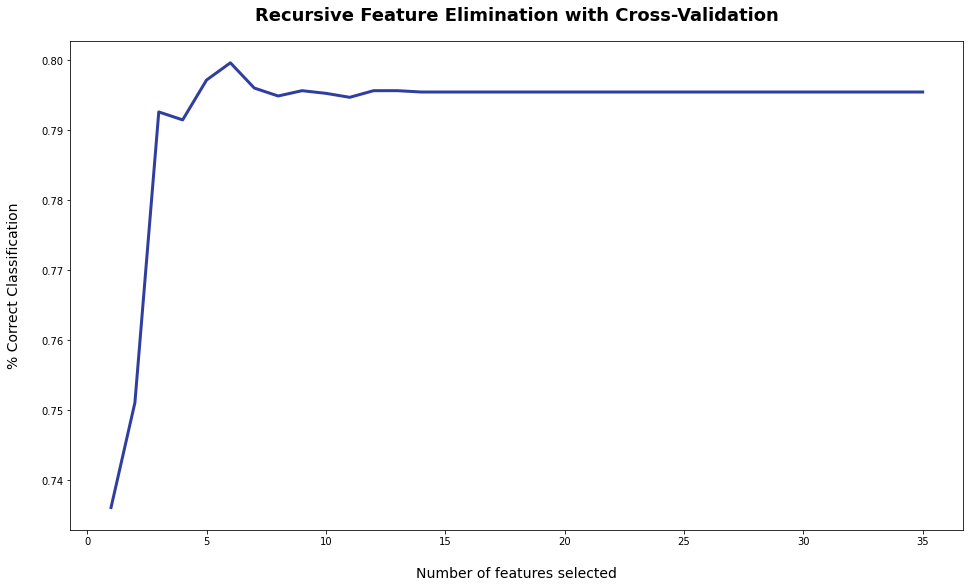

In [36]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(Decision_rfecv.cv_results_['mean_test_score']) + 1), Decision_rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
plt.show()

## Decision tree - feature importance

In [37]:
Decision_rfecv_imp = Decision_rfecv_model.estimator_.feature_importances_

In [38]:
X_D = X_train.copy()
X_D_Dropped = X_D.drop(X_D.columns[np.where(Decision_rfecv.support_ == False)[0]], axis=1, inplace=True)


In [39]:
#Get the col names of Decision tree
d_colname=list(X_D.columns)
#d_colname

In [40]:
#Create dict for datafram
rfecv_dict={'Feature':d_colname,'Importance':Decision_rfecv_imp}

#Create dataframe
rfecv_feature_imp=pd.DataFrame(rfecv_dict).sort_values(by='Importance',ascending = False)

In [41]:
rfecv_feature_imp

,Feature,Importance
5,Contract_Month-to-month,0.511898
0,tenure,0.183504
3,InternetService_Fiber optic,0.157295
2,TotalCharges,0.074111
1,MonthlyCharges,0.048152
4,InternetService_No,0.025040


In [42]:
len(Decision_rfecv_model.support_)

35

In [43]:
#Print results
print('Optimal feature amount:',Decision_rfecv_model.n_features_)
# Here we look into our orignal columns to see which are listen in our Recursive model of features
print('Chosen features:', list(X.columns[Decision_rfecv_model.support_]))

Optimal feature amount: 6
Chosen features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month']


## Decision three with cross validation - Accuracy result

In [44]:
# WE find the acuracy of our model
dc_prediction = Decision_rfecv.predict(X_test)
print(classification_report(y_test, dc_prediction, digits=4))

              precision    recall  f1-score   support

           0     0.8442    0.8462    0.8452      1281
           1     0.5844    0.5807    0.5825       477

    accuracy                         0.7742      1758
   macro avg     0.7143    0.7135    0.7139      1758
weighted avg     0.7737    0.7742    0.7740      1758



In [45]:
print('Accuracy of Decision tree classifier on test set: {:.5f}'.format(Decision_rfecv.score(X_test, y_test)))

Accuracy of Decision tree classifier on test set: 0.77418


## decision tree cross - confusion matrix 

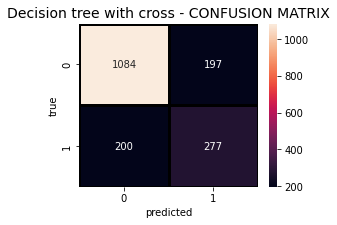

In [46]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, dc_prediction),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

plt.xlabel("predicted")
plt.ylabel("true")
plt.title("Decision tree with cross - CONFUSION MATRIX",fontsize=14)
plt.show()

## Random forrest - without cross validation

In [47]:
# Initialize the training set and test set
#Split the  Splits at 25% default
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=69
)

In [48]:
X_train.shape

(5274, 35)

In [49]:

# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define dataset
# define models and parameters
rf_model = RandomForestClassifier()

n_estimators = [10, 100, 200, 1000]
max_depth = [1,2,4,6,7,10,20]
# define grid search
rf_grid = dict(
    n_estimators=n_estimators,
    max_depth = max_depth
)

# estimator = our model we want to find the best params from
# param_grid = is our parameter we want to use
# n_jobs = Number of jobs to run in parallel, we dont need that
# We have used the gridSearchCV without the crossvalidation CV


rf_grid_search = GridSearchCV(
  estimator=rf_model, 
  param_grid=rf_grid, 
  n_jobs=-1, 
  scoring='accuracy',
  error_score=0
)

rf_grid_result = rf_grid_search.fit(X,y)

# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
means = rf_grid_result.cv_results_['mean_test_score']
stds = rf_grid_result.cv_results_['std_test_score']
params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.803895 using {'max_depth': 10, 'n_estimators': 100}
0.734215 (0.000261) with: {'max_depth': 1, 'n_estimators': 10}
0.734215 (0.000261) with: {'max_depth': 1, 'n_estimators': 100}
0.734215 (0.000261) with: {'max_depth': 1, 'n_estimators': 200}
0.734215 (0.000261) with: {'max_depth': 1, 'n_estimators': 1000}
0.750004 (0.017298) with: {'max_depth': 2, 'n_estimators': 10}
0.743033 (0.007037) with: {'max_depth': 2, 'n_estimators': 100}
0.740329 (0.003020) with: {'max_depth': 2, 'n_estimators': 200}
0.742320 (0.004533) with: {'max_depth': 2, 'n_estimators': 1000}
0.788821 (0.009163) with: {'max_depth': 4, 'n_estimators': 10}
0.790102 (0.006775) with: {'max_depth': 4, 'n_estimators': 100}
0.789391 (0.008371) with: {'max_depth': 4, 'n_estimators': 200}
0.789960 (0.009446) with: {'max_depth': 4, 'n_estimators': 1000}
0.797211 (0.008201) with: {'max_depth': 6, 'n_estimators': 10}
0.801335 (0.010079) with: {'max_depth': 6, 'n_estimators': 100}
0.801051 (0.009477) with: {'max_depth': 6, 'n

In [50]:
# Create random forest classifer object that uses entropy - very slow
rfc = RandomForestClassifier(random_state=50, n_jobs=-1 , n_estimators=200, max_depth=7)
# Train model
rfc_model = rfc.fit(X_train, y_train)
# Predict    
y_pred_rfc = rfc_model.predict(X_test)

In [51]:
print('Accuracy of random forest classifier on test set: {:.5f}'.format(rfc_model.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.79238


### rf accuracy result

In [52]:
print(classification_report(y_test,y_pred_rfc,digits=4))

              precision    recall  f1-score   support

           0     0.8290    0.9009    0.8634      1281
           1     0.6530    0.5010    0.5670       477

    accuracy                         0.7924      1758
   macro avg     0.7410    0.7010    0.7152      1758
weighted avg     0.7813    0.7924    0.7830      1758



In [53]:
rfc_imp=list(rfc_model.feature_importances_)

In [54]:

rfc_colname=list(X_train.columns)

#Create dict for datafram
rfc_dict={'Feature':rfc_colname,'Importance':rfc_imp}

#Create dataframe
rfc_feature_imp=pd.DataFrame(rfc_dict)

In [55]:
rfc_feature_rank=rfc_feature_imp.sort_values(by='Importance',ascending = False)

## rf - feature importance - result

In [56]:
rfc_feature_rank.head(10)

,Feature,Importance
0,tenure,0.171213
26,Contract_Month-to-month,0.142748
2,TotalCharges,0.105233
1,MonthlyCharges,0.086052
12,InternetService_Fiber optic,0.085551
28,Contract_Two year,0.058818
33,PaymentMethod_Electronic check,0.055265
13,InternetService_No,0.041493
27,Contract_One year,0.024797
15,OnlineSecurity_Yes,0.022690


# rf - confusion matrix - result

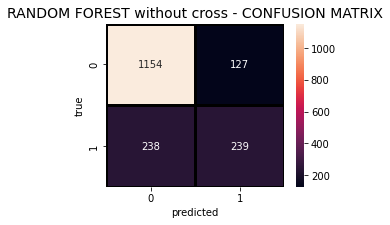

In [57]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("RANDOM FOREST without cross - CONFUSION MATRIX",fontsize=14)
plt.show()

# Random forest with cross validation

In [58]:
X.shape

(7032, 35)

In [59]:

# Train model with Cross validation
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(6), scoring='accuracy')

rfecv_model = rfecv.fit(X_train, y_train)
# Predict    
y_pred_rfcv = rfecv_model.predict(X_test)

In [60]:
#Print results
print('Optimal feature amount:',rfecv_model.n_features_)
# Here we look into our orignal columns to see which are listen in our Recursive model of features
print('Chosen features:', list(X.columns[rfecv_model.support_]))

Optimal feature amount: 21
Chosen features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_No', 'SeniorCitizen_Yes', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'TechSupport_No', 'TechSupport_Yes', 'StreamingMovies_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check']


In [61]:
#plt.figure(figsize=(16, 9))
#plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
#plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
#plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
#plt.plot(range(1, len(rfecv_model.cv_results_['mean_test_score']) + 1), rfecv_model.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
#plt.show()

### rf feature importance cross - result

In [62]:
# Initialize the training set and test set
#Split the  Splits at 25% default
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=69
)

In [63]:
rfecv_imp = rfecv_model.estimator_.feature_importances_

In [64]:
#Show which index should be deleted
#print(np.where(rfecv.support_ == False)[0])

In [65]:
len(X.columns)

35

In [66]:
#Remove the none important features
X_rf = X_train.copy()
X_Dropped =  (len(X_rf.columns) != 32) and X_rf.drop(X_rf.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

In [67]:
len(X_rf.columns)

21

In [68]:
rfecv_colname=list(X_rf.columns)

In [69]:
#Create dict for datafram
rfecv_dict={'Feature':rfecv_colname,'Importance':rfecv_imp}

#Create dataframe
rfecv_feature_imp=pd.DataFrame(rfecv_dict)

In [70]:
rfecv_feature_rank = rfecv_feature_imp.sort_values(by='Importance',ascending = False)

In [71]:
rfecv_feature_rank.head(10)

,Feature,Importance
15,Contract_Month-to-month,0.186980
0,tenure,0.172454
2,TotalCharges,0.120902
1,MonthlyCharges,0.096529
7,InternetService_Fiber optic,0.085973
17,Contract_Two year,0.057863
20,PaymentMethod_Electronic check,0.057496
8,InternetService_No,0.038538
16,Contract_One year,0.023823
6,InternetService_DSL,0.022686


## rf accuracy cross result

In [72]:
print('Accuracy of random forest classifier on test set: {:.5f}'.format(rfecv_model.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.78953


In [73]:
print(classification_report(y_test,y_pred_rfcv, digits=4))

              precision    recall  f1-score   support

           0     0.8294    0.8954    0.8611      1281
           1     0.6427    0.5052    0.5657       477

    accuracy                         0.7895      1758
   macro avg     0.7360    0.7003    0.7134      1758
weighted avg     0.7787    0.7895    0.7810      1758



## rf cross - confusion matrix - result

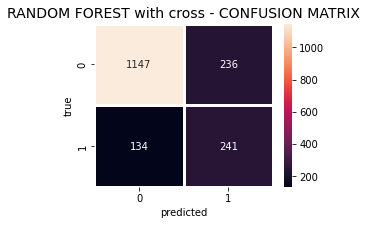

In [74]:
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
plt.figure(figsize=(4,3))
sns.heatmap(
    confusion_matrix(
        y_pred_rfcv,
        y_test
    ),
    annot=True,
    fmt = "d",
    linewidths=3
)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("RANDOM FOREST with cross - CONFUSION MATRIX",fontsize=14)
plt.show()

# Logistic regression

## Logistic regression - without RFECV

In [75]:
# Save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [76]:
# Instantiate min-max scaling object
mm = MinMaxScaler()
# Fit and transform our feature dataframe
X = pd.DataFrame(mm.fit_transform(X))
# Reassign column names so new dataframe has corresponding names
X.columns = cols

In [77]:
# Initialize the training set and test set
#Split the  Splits at 25% default
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=69
)

### Find optimal hyperparameter

In [78]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define models and parameters
lr_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
lr_grid = dict(
    solver=solvers,
    C=c_values
)

lr_grid_search = GridSearchCV(
    estimator = lr_model,
     param_grid = lr_grid, 
     n_jobs = -1,
     scoring = 'accuracy',
     error_score = 0
)

lr_grid_result = lr_grid_search.fit(X,y)
# summarize results
print("Best: %f using %s" % (lr_grid_result.best_score_, lr_grid_result.best_params_))
means = lr_grid_result.cv_results_['mean_test_score']
stds = lr_grid_result.cv_results_['std_test_score']
params = lr_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.804891 using {'C': 1.0, 'solver': 'newton-cg'}
0.804322 (0.009341) with: {'C': 100, 'solver': 'newton-cg'}
0.804037 (0.009280) with: {'C': 100, 'solver': 'lbfgs'}
0.804179 (0.009235) with: {'C': 100, 'solver': 'liblinear'}
0.804037 (0.008366) with: {'C': 10, 'solver': 'newton-cg'}
0.804037 (0.008366) with: {'C': 10, 'solver': 'lbfgs'}
0.804037 (0.008366) with: {'C': 10, 'solver': 'liblinear'}
0.804891 (0.006796) with: {'C': 1.0, 'solver': 'newton-cg'}
0.804749 (0.006659) with: {'C': 1.0, 'solver': 'lbfgs'}
0.804749 (0.006647) with: {'C': 1.0, 'solver': 'liblinear'}
0.801905 (0.006324) with: {'C': 0.1, 'solver': 'newton-cg'}
0.802047 (0.006358) with: {'C': 0.1, 'solver': 'lbfgs'}
0.802332 (0.006660) with: {'C': 0.1, 'solver': 'liblinear'}
0.791096 (0.005803) with: {'C': 0.01, 'solver': 'newton-cg'}
0.791096 (0.005803) with: {'C': 0.01, 'solver': 'lbfgs'}
0.793371 (0.006166) with: {'C': 0.01, 'solver': 'liblinear'}


In [79]:
# Create classifier with logistic regression
logreg = LogisticRegression(C = 0.1, solver ='newton-cg', random_state=50)


In [80]:
#Fit model
logreg_model = logreg.fit(X_train,y_train)

#Predict
Log_y_pred_logreg = logreg_model.predict(X_test)

## LR Accuracy without RFECV - Result

In [81]:
print('Accuracy of LR classifier on test without RFECV: {:.10f}'.format(logreg_model.score(X_test, y_test)))

Accuracy of LR classifier on test without RFECV: 0.7878270762


In [82]:
print(classification_report(y_test,Log_y_pred_logreg, digits=4))

              precision    recall  f1-score   support

           0     0.8290    0.8931    0.8598      1281
           1     0.6376    0.5052    0.5637       477

    accuracy                         0.7878      1758
   macro avg     0.7333    0.6991    0.7118      1758
weighted avg     0.7770    0.7878    0.7795      1758



## LR - without RFECV - confusion matrix - result

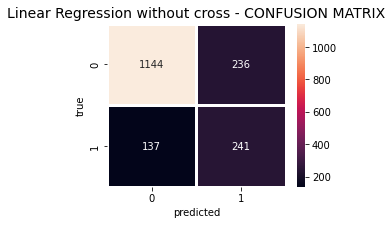

In [83]:
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
plt.figure(figsize=(4,3))
sns.heatmap(
    confusion_matrix(
        Log_y_pred_logreg,
        y_test
    ),
    annot=True,
    fmt = "d",
    linewidths=3
)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("Linear Regression without cross - CONFUSION MATRIX",fontsize=14)
plt.show()


### Feature importance

In [84]:
importance = logreg.coef_[0]

In [85]:
log_imp=list(importance)

In [86]:
log_colname=list(X.columns)

In [87]:
#Create dict for datafram
log_dict={'Column_Names_rfc':log_colname,'coaf':log_imp}

#Create dataframe
log_feature_imp = pd.DataFrame(log_dict)

log_feature_rank = log_feature_imp.sort_values(by='coaf',ascending = False)

log_feature_rank.head(10)

,Column_Names_rfc,coaf
12,InternetService_Fiber optic,0.759317
26,Contract_Month-to-month,0.734109
33,PaymentMethod_Electronic check,0.254819
14,OnlineSecurity_No,0.216948
20,TechSupport_No,0.146948
25,StreamingMovies_Yes,0.146417
30,PaperlessBilling_Yes,0.141776
4,SeniorCitizen_Yes,0.121023
1,MonthlyCharges,0.111504
10,MultipleLines_Yes,0.107372


# LR with RFECV


In [88]:
# create our LR_model
rfecv_LR = RFECV(estimator=logreg_model, cv=StratifiedKFold(6), scoring="accuracy")

# Fit the model to our X and y training sets
rfecv_model_LR = rfecv_LR.fit(X_train, y_train)

#predict
y_pred_rfcv_LR = rfecv_model_LR.predict(X_test)

In [89]:
#Print results
print('Optimal feature amount:',rfecv_model_LR.n_features_)
# Here we look into our orignal columns to see which are listen in our Recursive model of features
print('Chosen features that have been removed:', list(X.columns[rfecv_model_LR.support_] ^ X.columns))

Optimal feature amount: 25
Chosen features that have been removed: ['Contract_One year', 'Dependents_No', 'DeviceProtection_No', 'DeviceProtection_Yes', 'InternetService_DSL', 'Partner_No', 'Partner_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check']


In [90]:
print('Accuracy of LR classifier on test with RFECV:: {:.10}'.format(rfecv_model_LR.score(X_test, y_test)))

Accuracy of LR classifier on test with RFECV:: 0.7912400455


In [91]:
print(classification_report(y_test,y_pred_rfcv_LR, digits=4))

              precision    recall  f1-score   support

           0     0.8307    0.8962    0.8622      1281
           1     0.6463    0.5094    0.5698       477

    accuracy                         0.7912      1758
   macro avg     0.7385    0.7028    0.7160      1758
weighted avg     0.7806    0.7912    0.7828      1758



In [92]:
#Get the coef
rfecv_imp_LR = list(rfecv_model_LR.estimator_.coef_[0])

In [93]:
#Get Cols
X_LR = X.copy()
len(X_LR.columns)

35

In [94]:
rfecv_colName_LR = X_LR.drop(X_LR.columns[np.where(rfecv_model_LR.support_ == False)[0]], axis=1, inplace=True)
LR_Colnames = list(X_LR.columns)
len(LR_Colnames)


25

In [95]:
#Create dict for datafram
rfecv_dict_LR = {'Feature':LR_Colnames,'Coaf':rfecv_imp_LR}

In [96]:
#Create dataframe
rfecv_feature_imp_LR = pd.DataFrame(rfecv_dict_LR)

In [97]:
# SOrt the table for coef
rfecv_feature_coef = rfecv_feature_imp_LR.sort_values(by='Coaf',ascending = False)


In [98]:
rfecv_feature_coef

,Feature,Coaf
20,Contract_Month-to-month,0.782372
8,InternetService_Fiber optic,0.714191
24,PaymentMethod_Electronic check,0.334081
10,OnlineSecurity_No,0.216929
19,StreamingMovies_Yes,0.146231
14,TechSupport_No,0.146193
23,PaperlessBilling_Yes,0.142145
4,SeniorCitizen_Yes,0.116314
7,MultipleLines_Yes,0.106160
1,MonthlyCharges,0.105806


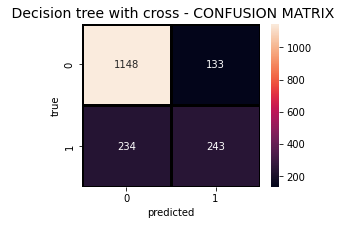

In [99]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_rfcv_LR),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" Decision tree with cross - CONFUSION MATRIX",fontsize=14)
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()